<span style="font-size: 15px;">
 ----------------------------------------------------------------- <br>
 Project: House Prices Prediction <br>
 Author: Jairo Macedo <br>
 Created: June 2024 <br>
 Last Modified: [04, 2025] | By: Jairo Macedo <br>
 ----------------------------------------------------------------- <br>
 Description: <br>
 This Python notebook contains the code and analysis for the project <br>
 "House Prices Prediction". The goal is to model and predict house prices <br>
 using a variety of property features. The dataset comes from a Kaggle <br>
 competition and includes rich details about homes and their sale prices. <br>
 ----------------------------------------------------------------- <br>
 The analysis is structured as follows: <br>
 1. Data Import and Exploration: Loading and understanding the dataset. <br>
 2. Feature Engineering: Creating and selecting relevant variables. <br>
 3. Modeling: Applying and tuning machine learning models to predict prices. <br>
 4. Evaluation: Assessing model performance and accuracy. <br>
 5. Submission: Preparing results for Kaggle submission. <br>
 ----------------------------------------------------------------- <br>

<br>
<b>Clean Dataset Files</b> <br>
- <code>train_2.csv</code> – The cleaned and preprocessed training set <br>
- <code>test_2.csv</code> – The cleaned and preprocessed test set <br>
</span>



# Packages ⚙️ and data 🗂️

In [142]:
# ================================
# Data Handling and Utilities
# ================================
import pandas as pd            # Data manipulation
import numpy as np             # Numerical operations

import matplotlib.pyplot as plt # Visualization and diagnostic plots

import zipfile                 # Reading compressed .zip files
from support import zip_path   # Path to the .zip file
from support import results_path  # Importing the path for saving results

import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Machine Learning Models
# ================================
from sklearn.model_selection import train_test_split   # Splitting dataset into training and testing sets
from sklearn.linear_model import LinearRegression      # Ordinary Least Squares (baseline model)
from sklearn import tree                               # Decision Tree Regressor (non-parametric model)
from sklearn.neighbors import KNeighborsRegressor      # K-Nearest Neighbors Regressor (non-parametric model)

# ================================
# Model Evaluation Metrics
# ================================
from sklearn.metrics import mean_absolute_error        # Mean Absolute Error (MAE)
from sklearn.metrics import mean_squared_error         # Mean Squared Error (MSE and RMSE)
from sklearn.metrics import r2_score                   # R-squared (goodness-of-fit)

In [143]:
# Setting the global random seed for reproducibility
np.random.seed(42)

In [144]:
# Open the zip and read train.csv directly
with zipfile.ZipFile(zip_path) as z:
    with z.open('train.csv') as f:
        df_train = pd.read_csv(f)

In [145]:
# Open the zip and read test.csv directly
with zipfile.ZipFile(zip_path) as z:
    with z.open('test.csv') as f:
        df_test = pd.read_csv(f)

# Hi, data! 👋

### Explore it

In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [147]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [148]:
# Check for missing values (Top 20)
missing_percent = (df_train.isnull().sum() / df_train.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

PoolQC          99.52%
MiscFeature     96.30%
Alley           93.77%
Fence           80.75%
MasVnrType      59.73%
FireplaceQu     47.26%
LotFrontage     17.74%
GarageQual       5.55%
GarageFinish     5.55%
GarageType       5.55%
GarageYrBlt      5.55%
GarageCond       5.55%
BsmtFinType2     2.60%
BsmtExposure     2.60%
BsmtCond         2.53%
BsmtQual         2.53%
BsmtFinType1     2.53%
MasVnrArea       0.55%
Electrical       0.07%
Condition2       0.00%
dtype: object


<a id='4top'></a>

- **The first 4 columns have more than 80% missing values in the training set**
    - Instead of dropping these columns, let's understand what each one represents:
        - **PoolQC**: **Quality** of the pool  
            - NA: No Pool  
        - **MiscFeature**: Miscellaneous features not covered in other categories  
            - NA: None  
        - **Alley**: Type of alley access to the property  
            - NA: No alley access  
        - **Fence**: **Quality** of the fence  
            - NA: No Fence  

- In these cases, **NA is not missing data, <font color= '#A22538' >it is information</font>**

- Therefore, we should explore the values in these columns and their **relationship with the sale price**


In [149]:
# Check for missing values (Top 20)
missing_percent = (df_test.isnull().sum() / df_test.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

PoolQC          99.79%
MiscFeature     96.50%
Alley           92.67%
Fence           80.12%
MasVnrType      61.27%
FireplaceQu     50.03%
LotFrontage     15.56%
GarageYrBlt      5.35%
GarageCond       5.35%
GarageFinish     5.35%
GarageQual       5.35%
GarageType       5.21%
BsmtCond         3.08%
BsmtQual         3.02%
BsmtExposure     3.02%
BsmtFinType1     2.88%
BsmtFinType2     2.88%
MasVnrArea       1.03%
MSZoning         0.27%
BsmtHalfBath     0.14%
dtype: object


### Data cleaning 

In [150]:
# We can replace the missing values in the first column with -1
df_train[['PoolQC','MiscFeature','Alley','Fence']] = df_train[['PoolQC','MiscFeature','Alley','Fence']].fillna(-1)

In [151]:
# We can replace the missing values in the first column with -1
df_test[['PoolQC','MiscFeature','Alley','Fence']] = df_test[['PoolQC','MiscFeature','Alley','Fence']].fillna(-1)

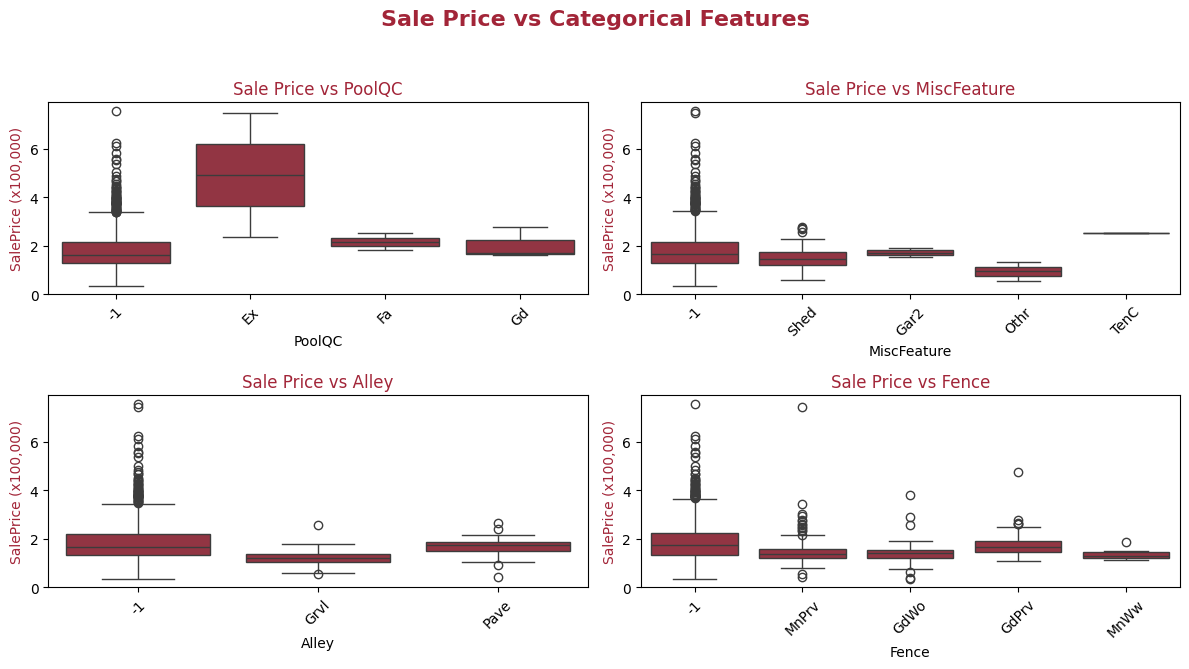

In [152]:
# Visualizing the relationship between categorical features and SalePrice with custom color

# Custom color (dark wine red)
rgb_color = (162 / 255, 37 / 255, 56 / 255)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 7))
fig.suptitle('Sale Price vs Categorical Features', fontsize=16, fontweight='bold', color=rgb_color)

sns.boxplot(x=df_train.PoolQC, y=df_train.SalePrice / 100000, ax=ax[0,0], color=rgb_color)
ax[0,0].set_ylabel('SalePrice (x100,000)', color=rgb_color)
ax[0,0].set_title('Sale Price vs PoolQC', color=rgb_color)
ax[0,0].tick_params(axis='x', rotation=45)

sns.boxplot(x=df_train.MiscFeature, y=df_train.SalePrice / 100000, ax=ax[0,1], color=rgb_color)
ax[0,1].set_ylabel('SalePrice (x100,000)', color=rgb_color)
ax[0,1].set_title('Sale Price vs MiscFeature', color=rgb_color)
ax[0,1].tick_params(axis='x', rotation=45)

sns.boxplot(x=df_train.Alley, y=df_train.SalePrice / 100000, ax=ax[1,0], color=rgb_color)
ax[1,0].set_ylabel('SalePrice (x100,000)', color=rgb_color)
ax[1,0].set_title('Sale Price vs Alley', color=rgb_color)
ax[1,0].tick_params(axis='x', rotation=45)

sns.boxplot(x=df_train.Fence, y=df_train.SalePrice / 100000, ax=ax[1,1], color=rgb_color)
ax[1,1].set_ylabel('SalePrice (x100,000)', color=rgb_color)
ax[1,1].set_title('Sale Price vs Fence', color=rgb_color)
ax[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<a id='FireplaceQu'></a>
- **Now analyzing the <font color='#A22538'>FireplaceQu</font> column**
- There are 2 fireplace-related columns:
    - **Fireplaces**: Number of fireplaces  
    - **FireplaceQu**: Fireplace quality

In [153]:
# Visualizing the number of records in each label
df_train[['Fireplaces', 'FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            690
1           Gd             324
            TA             259
2           Gd              54
            TA              53
1           Fa              28
            Po              20
            Ex              19
2           Fa               4
            Ex               4
3           Gd               2
            Ex               1
            Fa               1
            TA               1
Name: count, dtype: int64

In [154]:
# Visualizing the number of records in each label
df_test[['Fireplaces', 'FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            730
1           Gd             303
            TA             236
2           Gd              58
            TA              39
1           Fa              35
            Po              26
            Ex              18
2           Fa               6
3           TA               3
            Gd               3
2           Ex               1
4           TA               1
Name: count, dtype: int64

In [155]:
# Adjusting this column
# This NaN is also meaningful — it indicates that there is no fireplace
df_train[['FireplaceQu']] = df_train[['FireplaceQu']].fillna(-1)

In [156]:
# Adjusting this column
# This NaN is also meaningful — it indicates that there is no fireplace
df_test[['FireplaceQu']] = df_test[['FireplaceQu']].fillna(-1)

In [157]:
# Check for missing values (Top 20)
missing_percent = (df_train.isnull().sum() / df_train.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

MasVnrType      59.73%
LotFrontage     17.74%
GarageType       5.55%
GarageCond       5.55%
GarageFinish     5.55%
GarageYrBlt      5.55%
GarageQual       5.55%
BsmtExposure     2.60%
BsmtFinType2     2.60%
BsmtQual         2.53%
BsmtCond         2.53%
BsmtFinType1     2.53%
MasVnrArea       0.55%
Electrical       0.07%
Id               0.00%
MSZoning         0.00%
MSSubClass       0.00%
HouseStyle       0.00%
BldgType         0.00%
Condition2       0.00%
dtype: object


In [158]:
# Check for missing values (Top 20)
missing_percent = (df_test.isnull().sum() / df_test.shape[0] * 100).sort_values(ascending=False).head(20)
missing_percent = missing_percent.apply(lambda x: f"{x:.2f}%")
print(missing_percent)

del missing_percent

MasVnrType      61.27%
LotFrontage     15.56%
GarageYrBlt      5.35%
GarageQual       5.35%
GarageFinish     5.35%
GarageCond       5.35%
GarageType       5.21%
BsmtCond         3.08%
BsmtQual         3.02%
BsmtExposure     3.02%
BsmtFinType1     2.88%
BsmtFinType2     2.88%
MasVnrArea       1.03%
MSZoning         0.27%
Utilities        0.14%
BsmtHalfBath     0.14%
BsmtFullBath     0.14%
Functional       0.14%
KitchenQual      0.07%
BsmtFinSF2       0.07%
dtype: object


In [159]:
# Checking the number of missing values
df_train.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      872
LotFrontage     259
GarageType       81
GarageCond       81
GarageFinish     81
GarageYrBlt      81
GarageQual       81
BsmtExposure     38
BsmtFinType2     38
BsmtQual         37
dtype: int64

In [160]:
# Checking the number of missing values
df_test.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      894
LotFrontage     227
GarageYrBlt      78
GarageQual       78
GarageFinish     78
GarageCond       78
GarageType       76
BsmtCond         45
BsmtQual         44
BsmtExposure     44
dtype: int64

<a id='LotFrontage'></a>
- **<font color='#A22538'>LotFrontage</font>: Linear feet of street connected to the property**


In [161]:
# Understanding the types of properties with missing values
df_train.loc[df_train.LotFrontage.isnull(), 'LotConfig'].value_counts()

LotConfig
Inside     134
Corner      62
CulDSac     49
FR2         14
Name: count, dtype: int64

In [162]:
# Checking the average LotFrontage by property type
df_train.groupby('LotConfig')['LotFrontage'].mean()

LotConfig
Corner     84.039801
CulDSac    59.911111
FR2        63.515152
FR3        70.750000
Inside     67.715686
Name: LotFrontage, dtype: float64

In [163]:
# In this case, the missing value seems to be a data issue
# Replacing missing values with the mean based on LotConfig
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(df_train.groupby('LotConfig')['LotFrontage'].transform('mean'))

df_test['LotFrontage'] = df_test['LotFrontage'].fillna(df_test.groupby('LotConfig')['LotFrontage'].transform('mean'))

<a id="garagem"></a>
- **Evaluating the <font color='#A22538'>garage-related columns</font>**
    - **GarageType**: Garage location  
        - **NA: No Garage**  
    - **GarageYrBlt**: Year the garage was built  
    - **GarageFinish**: Interior finish of the garage  
        - **NA: No Garage**  
    - **GarageCars**: Garage size in car capacity  
    - **GarageArea**: Garage size in square feet  
    - **GarageQual**: Garage quality  
        - **NA: No Garage**  
    - **GarageCond**: Garage condition  
        - **NA: No Garage**

- **<font color= '#A22538'>Data train</font>**

In [164]:
# Checking for columns that contain 'Garage' in their name
col = df_train.columns[df_train.columns.str.contains("Garage")]

# Filtering the dataset
df_train.loc[df_train.GarageType.isnull(), col].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0           0           NaN         NaN           81
Name: count, dtype: int64

In [165]:
# Checking for columns that contain 'Garage' in their name
col = df_train.columns[df_train.columns.str.contains("Garage")]

# We can select only the columns with missing values
df_train.loc[df_train.GarageType.isnull(), col[[0,1,2,5,6]]].head(3)

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN


In [166]:
# Checking for columns that contain 'Garage' in their name
col = df_train.columns[df_train.columns.str.contains("Garage")]

# Checking the values if there is NA in a column and other is not NA
df_train.loc[df_train.GarageType.isnull(), col[[0,1,2,5,6]]].value_counts(dropna=False) 

GarageType  GarageYrBlt  GarageFinish  GarageQual  GarageCond
NaN         NaN          NaN           NaN         NaN           81
Name: count, dtype: int64

In [167]:
# Checking for columns that contain 'Garage' in their name
col = df_train.columns[df_train.columns.str.contains("Garage")]

# And replace these values with -1
df_train.loc[df_train.GarageType.isnull(), col[[0,1,2,5,6]]] = -1

In [168]:
# Checking for columns that contain 'Garage' in their name
col= df_train.columns[df_train.columns.str.contains("Garage")]

# Checking again when the number of cars is equal to 0
df_train.loc[df_train.GarageCars == 0, col].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
-1          -1.0         -1            0           0           -1          -1            81
Name: count, dtype: int64

In [169]:
# Summarizing missing values in the training dataset
df_train.isnull().sum().sort_values(ascending=False).head(9)

MasVnrType      872
BsmtExposure     38
BsmtFinType2     38
BsmtCond         37
BsmtFinType1     37
BsmtQual         37
MasVnrArea        8
Electrical        1
LandContour       0
dtype: int64

- **<font color= '#A22538'>Data test</font>**

In [170]:
# Summarizing missing values in the training dataset                          
df_test.isnull().sum().sort_values(ascending=False).head(9)

MasVnrType      894
GarageFinish     78
GarageYrBlt      78
GarageQual       78
GarageCond       78
GarageType       76
BsmtCond         45
BsmtQual         44
BsmtExposure     44
dtype: int64

In [171]:
# Checking for columns that contain 'Garage' in their name
col = df_test.columns[df_test.columns.str.contains("Garage")]

# Checking the values if there is NA in a column and other is not NA
df_test.loc[df_test.GarageCond.isnull(), col].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0.0         0.0         NaN         NaN           76
Detchd      NaN          NaN           1.0         360.0       NaN         NaN            1
                                       NaN         NaN         NaN         NaN            1
Name: count, dtype: int64

In [172]:
# Checking for columns that contain 'Garage' in their name
col = df_test.columns[df_test.columns.str.contains("Garage")]

# We can select only the columns with missing values
df_test.loc[df_test.GarageType.isnull(), col[[0,1,2,5,6]]].head(3)

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
53,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN


In [173]:
# Checking for columns that contain 'Garage' in their name
col = df_test.columns[df_test.columns.str.contains("Garage")]

# Checking the values, verify differences between columns
df_test.loc[df_test.GarageType.isnull(), col[[0,1,2,5,6]]].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageQual  GarageCond
NaN         NaN          NaN           NaN         NaN           76
Name: count, dtype: int64

In [174]:
# Checking for columns that contain 'Garage' in their name
col = df_test.columns[df_test.columns.str.contains("Garage")]

df_test.loc[df_test.GarageType.isnull(), col[[0,1,2,5,6]]] = -1

In [175]:
# Checking for columns that contain 'Garage' in their name
col= df_test.columns[df_test.columns.str.contains("Garage")]

# Checking again when the number of cars is equal to 0
df_test.loc[df_test.GarageCars == 0, col].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
-1          -1.0         -1            0.0         0.0         -1          -1            76
Name: count, dtype: int64

- Now let's investigate the rows where all garage-related columns are empty but `GarageType` is "Detchd"

In [176]:
# Understanding these columns
df_test.loc[df_test.GarageCond.isnull(), col]


,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


- Now let's investigate column GarageYrBlt

In [177]:
# Let's check the values when GarageType == "Detchd"
df_test2 = df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageYrBlt != -1)]

In [178]:
# 1. Filter the DataFrame to include only detached garages (Detchd) with valid year built
df_test2 = df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageYrBlt != -1)]

# 2. Select only numeric columns to avoid "could not convert string to float" error
df_test2_numeric = df_test2.select_dtypes(include='number')

# 3. Calculate the correlation of all numeric variables with 'GarageYrBlt'
top_corrs = df_test2_numeric.corr()['GarageYrBlt'].sort_values(ascending=False).head(5)
print(top_corrs)


GarageYrBlt     1.000000
YearBuilt       0.615951
GarageArea      0.494670
GarageCars      0.413711
YearRemodAdd    0.321667
Name: GarageYrBlt, dtype: float64


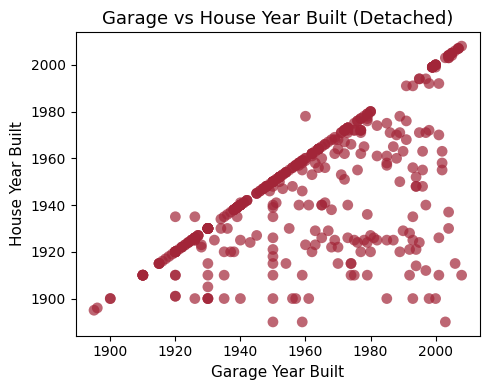

In [179]:
# Custom dark wine red color
rgb_color = (162 / 255, 37 / 255, 56 / 255)

# Set up a smaller figure
fig, ax = plt.subplots(figsize=(5, 4))  # smaller size

# Scatter plot
ax.scatter(df_test2.GarageYrBlt, df_test2.YearBuilt, color=rgb_color, alpha=0.7, edgecolors='none', s=60)

# Labels and title
ax.set_xlabel('Garage Year Built', fontsize=11)
ax.set_ylabel('House Year Built', fontsize=11)
ax.set_title('Garage vs House Year Built (Detached)', fontsize=13)

# No grid
ax.grid(False)

# Clean layout
plt.tight_layout()
plt.show()



In [180]:
# Create a new column that checks if the garage year is the same as the house year
df_test['CheckYears'] = df_test.GarageYrBlt == df_test.YearBuilt

# Count how many times the condition is True or False
df_test.CheckYears.value_counts()


CheckYears
True     1127
False     332
Name: count, dtype: int64

In [181]:
df_test = df_test.drop('CheckYears',axis=1)

In [182]:
# Check the house construction years for rows where GarageCond is missing
df_test.loc[df_test.GarageCond.isnull(), 'YearBuilt']

# Replace missing GarageYrBlt values with the house's construction year (YearBuilt)
df_test.loc[df_test.GarageCond.isnull(), 'GarageYrBlt'] = df_test.loc[df_test.GarageCond.isnull(), 'YearBuilt']


- Now let's investigate column GarageFinish

In [183]:
# Check the most frequent values of GarageFinish when GarageType is 'Detchd'
df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageFinish'].value_counts()

GarageFinish
Unf    365
RFn     15
Fin     10
Name: count, dtype: int64

In [184]:
# Get the mode of GarageFinish for 'Detchd' garage type
most_common_finish = df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageFinish'].mode()[0]
print(most_common_finish)

Unf


In [185]:
# Replace missing GarageFinish values with the mode, only for 'Detchd' garages
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageFinish.isnull()), 'GarageFinish'] = most_common_finish

- Now let's investigate column GarageQual and GarageCond

In [186]:
# Check value combinations of GarageQual and GarageCond when GarageType is 'Detchd'
df_test.loc[(df_test.GarageType == 'Detchd'), ['GarageQual', 'GarageCond']].value_counts()

GarageQual  GarageCond
TA          TA            309
Fa          TA             38
            Fa             19
TA          Fa             16
Fa          Po              3
Gd          Ex              1
Po          Po              1
            Fa              1
TA          Gd              1
            Po              1
Name: count, dtype: int64

In [187]:
# Get the mode for GarageQual and GarageCond among 'Detchd' garages
mode_garage_qual = df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageQual'].mode()[0]
mode_garage_cond = df_test.loc[(df_test.GarageType == 'Detchd'), 'GarageCond'].mode()[0]
print(mode_garage_qual, mode_garage_cond)

TA TA


In [188]:
# Replace missing GarageQual values with the most common one
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageQual.isnull()), 'GarageQual'] = mode_garage_qual
# Replace missing GarageCond values with the most common one
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageCond.isnull()), 'GarageCond'] = mode_garage_cond

- Column GarageCars and GarageArea

In [189]:
# Calculate the mean of GarageCars and GarageArea for detached garages
mean_values = df_test.loc[df_test.GarageType == 'Detchd', ['GarageCars', 'GarageArea']].mean()
print(mean_values)

GarageCars      1.519182
GarageArea    412.202046
dtype: float64


In [190]:
# Round the mean values (you can't have half a car!)
mean_values = round(mean_values, 0)
print(mean_values.values)

[  2. 412.]


In [191]:
# Fill missing values ONLY for GarageCars and GarageArea, for detached garages
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageCars.isnull()), 'GarageCars'] = mean_values['GarageCars']
df_test.loc[(df_test.GarageType == 'Detchd') & (df_test.GarageArea.isnull()), 'GarageArea'] = mean_values['GarageArea']

# Check how those values look in specific rows
df_test.iloc[[666, 1116], 55:70]

,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch
666,Typ,0,-1,Detchd,1910.0,Unf,1.0,360.0,TA,TA,Y,64,0,180,0
1116,Typ,0,-1,Detchd,1923.0,Unf,2.0,412.0,TA,TA,Y,174,0,212,0


In [192]:
# Summarize the 10 columns with the most missing values
df_test.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      894
BsmtCond         45
BsmtExposure     44
BsmtQual         44
BsmtFinType2     42
BsmtFinType1     42
MasVnrArea       15
MSZoning          4
BsmtFullBath      2
Utilities         2
dtype: int64

<a id="basement"></a>
- **Evaluating the <font color= '#A22538' >basement-related columns</font>**
    - **NA: No Basement**

In [193]:
# Checking columns that contain 'Bsmt' in the name and have missing values
col = df_train.columns[df_train.columns.str.contains("Bsmt") & (df_train.isnull().any())]
col

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], dtype='object')

In [194]:
# Analyzing the values
df_train.loc[df_train.BsmtFinType2.isnull(), col].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Gd        TA        No            GLQ           NaN              1
Name: count, dtype: int64

In [195]:
# Checking the value combinations of 'BsmtFinType2' and 'BsmtFinSF2' where 'BsmtFinType2' is missing
df_train.loc[df_train.BsmtFinType2.isnull(), ['BsmtFinType2', 'BsmtFinSF2']].value_counts(dropna=False)

BsmtFinType2  BsmtFinSF2
NaN           0             37
              479            1
Name: count, dtype: int64

In [196]:
# Checking the mode of BsmtFinType2
mod_BsmtFinType2 = df_train.BsmtFinType2.mode()[0]
mod_BsmtFinType2

'Unf'

In [197]:
# Replacing missing values with 'Unf' where BsmtFinSF2 is not 0
df_train.loc[(df_train.BsmtFinType2.isnull()) & (df_train.BsmtFinSF2 != 0), 'BsmtFinType2'] = mod_BsmtFinType2

In [198]:
# Analyzing the values for BsmtExposure
df_train.BsmtExposure.value_counts()

BsmtExposure
No    953
Av    221
Gd    134
Mn    114
Name: count, dtype: int64

In [199]:
# And again, we can see the most frequent value
mod_BsmtExposure = df_train.BsmtExposure.mode()[0]
mod_BsmtExposure

'No'

In [200]:
# Replacing missing values with "No" (the most frequent value)
df_train.loc[df_train.BsmtExposure.isnull(), 'BsmtExposure'] = mod_BsmtExposure

In [201]:
# Remembering the columns that contain 'Bsmt'
col

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], dtype='object')

In [202]:
# Checking columns that contain 'Bsmt' in the name and have missing values
col = df_test.columns[df_test.columns.str.contains("Bsmt") & (df_test.isnull().any())]
col

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [203]:
# Analyzing the values
df_test.loc[df_test.BsmtFinType2.isnull(), col].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          0.0           0.0             40
                                                                                                              NaN           NaN              1
                                                NaN         NaN           NaN         NaN        NaN          NaN           NaN              1
Name: count, dtype: int64

In [204]:
# Selecting rows where BsmtQual is missing but BsmtCond is present
df_test.loc[(df_test.BsmtQual.isnull()) & (df_test.BsmtCond.notnull()),col]


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0


In [205]:
# We can see the most frequent value
df_test.BsmtQual.mode()[0]

'TA'

In [206]:
# Replacing missing values with "No" (the most frequent value)
df_test.loc[(df_test.BsmtQual.isnull()) & (df_test.BsmtCond.notnull()),'BsmtQual'] = df_test.BsmtQual.mode()[0]

In [207]:
df_test.iloc[757:759,30:40]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating
757,TA,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA
758,TA,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA


In [208]:
df_test.loc[df_test.BsmtQual.isnull(),col].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          0.0           0.0             40
                                                                                                              NaN           NaN              1
                                                NaN         NaN           NaN         NaN        NaN          NaN           NaN              1
Name: count, dtype: int64

In [209]:
df_test.loc[df_test.BsmtQual.isnull(),['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = 0

df_test.loc[df_test.BsmtQual.isnull(),['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = -1

In [210]:
df_test.loc[df_test.BsmtQual.isnull(),col].value_counts(dropna=False)

Series([], Name: count, dtype: int64)

In [211]:
# Checking the number of missing values
df_test.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      894
MasVnrArea       15
MSZoning          4
BsmtCond          3
BsmtExposure      2
Utilities         2
Functional        2
Exterior2nd       1
Exterior1st       1
KitchenQual       1
dtype: int64

In [212]:
# BsmtCond
df_test.loc[df_test.BsmtCond.isnull(),col].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Gd        NaN       Mn            GLQ           1044.0      Rec           382.0       0.0        1426.0       1.0           0.0             1
TA        NaN       Av            ALQ           755.0       Unf           0.0         240.0      995.0        0.0           0.0             1
                    No            BLQ           1033.0      Unf           0.0         94.0       1127.0       0.0           1.0             1
Name: count, dtype: int64

In [213]:
df_test.BsmtCond.mode()[0]
df_test.loc[df_test.BsmtCond.isnull(),'BsmtCond'] = df_test.BsmtCond.mode()[0]

In [214]:
# BsmtExposure
df_test.loc[df_test.BsmtExposure.isnull(),col].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Gd        TA        NaN           Unf           0.0         Unf           0.0         725.0      725.0        0.0           0.0             1
                                                                                      1595.0     1595.0       0.0           0.0             1
Name: count, dtype: int64

In [215]:
df_test.loc[df_test.BsmtExposure.isnull(),'BsmtExposure'] = df_test.BsmtExposure.mode()[0]

In [216]:
# Verify train data
df_train.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      872
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
BsmtFinType2     37
MasVnrArea        8
Electrical        1
MSSubClass        0
LandContour       0
Utilities         0
dtype: int64

<a id='restante_teste'></a>
- **Analyzing the remaining test dataset**
- **Understanding these columns**
    - **<font color='#A22538'>MSZoning</font>**: Area where the house is located  
        - NA: The information was not added to the dataset (missing information)
    - **<font color='#A22538'>Functional</font>**: House functionalities  
        - NA: The information was not added to the dataset (missing information)
    - **<font color='#A22538'>Utilities</font>**: Available utilities  
        - NA: The information was not added to the dataset (missing information)


In [217]:
df_test.MSZoning.mode()[0]

'RL'

In [218]:
df_test.loc[df_test.MSZoning.isnull(),'MSZoning'] = df_test.MSZoning.mode()[0]

In [219]:
df_test.Utilities.value_counts()

Utilities
AllPub    1457
Name: count, dtype: int64

In [220]:
df_test.loc[df_test.Utilities.isnull(),'Utilities'] = df_test.Utilities.mode()[0]

In [221]:
df_test.Functional.value_counts()

Functional
Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: count, dtype: int64

In [222]:
df_test.loc[df_test.Functional.isnull(),'Functional'] = df_test.Functional.mode()[0]

In [223]:

print(df_test.Exterior2nd.mode()[0])
print(df_test.SaleType.mode()[0])
print(df_test.Exterior1st.mode()[0])
print(df_test.KitchenQual.mode()[0])

VinylSd
WD
VinylSd
TA


In [224]:

df_test.loc[df_test.Exterior2nd.isnull(),'Exterior2nd'] = df_test.Exterior2nd.mode()[0]
df_test.loc[df_test.SaleType.isnull(),'SaleType'] = df_test.SaleType.mode()[0]
df_test.loc[df_test.Exterior1st.isnull(),'Exterior1st'] = df_test.Exterior1st.mode()[0]
df_test.loc[df_test.KitchenQual.isnull(),'KitchenQual'] = df_test.KitchenQual.mode()[0]

In [225]:

df_test.isnull().sum().sort_values(ascending=False).head(5)

MasVnrType    894
MasVnrArea     15
Id              0
MSSubClass      0
LotArea         0
dtype: int64

In [226]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      872
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
BsmtFinType2     37
MasVnrArea        8
Electrical        1
MSSubClass        0
LandContour       0
Utilities         0
dtype: int64

In [227]:
df_train.to_csv('train_2.csv', index=False)
df_test.to_csv('test_2.csv', index=False)